#SECTION 1

In [ ]:
!pip install wandb


In [ ]:
# 890565723bd72b0f79842f61f64ac40de2ea4815

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import wandb
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [ ]:
wandb.init(project="mlp-iris-tracking", name="MLP_Iris_Experiment")

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target

ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y.reshape(-1, 1))

X_train, X_temp, y_train, y_temp = train_test_split(X, y_onehot, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train, y_train = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)
X_val, y_val = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32)
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)

train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader = data.DataLoader(data.TensorDataset(X_val, y_val), batch_size=32, shuffle=False)
test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=32, shuffle=False)


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    wandb.log({"epoch": epoch+1, "train_loss": train_loss, "val_loss": val_loss})

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/50 - Train Loss: 1.0882, Val Loss: 1.0747
Epoch 2/50 - Train Loss: 1.0814, Val Loss: 1.0663
Epoch 3/50 - Train Loss: 1.0711, Val Loss: 1.0581
Epoch 4/50 - Train Loss: 1.0711, Val Loss: 1.0495
Epoch 5/50 - Train Loss: 1.0598, Val Loss: 1.0411
Epoch 6/50 - Train Loss: 1.0533, Val Loss: 1.0321
Epoch 7/50 - Train Loss: 1.0487, Val Loss: 1.0226
Epoch 8/50 - Train Loss: 1.0515, Val Loss: 1.0132
Epoch 9/50 - Train Loss: 1.0324, Val Loss: 1.0038
Epoch 10/50 - Train Loss: 1.0275, Val Loss: 0.9937
Epoch 11/50 - Train Loss: 1.0240, Val Loss: 0.9835
Epoch 12/50 - Train Loss: 1.0160, Val Loss: 0.9730
Epoch 13/50 - Train Loss: 1.0135, Val Loss: 0.9625
Epoch 14/50 - Train Loss: 1.0012, Val Loss: 0.9517
Epoch 15/50 - Train Loss: 1.0016, Val Loss: 0.9408
Epoch 16/50 - Train Loss: 0.9976, Val Loss: 0.9299
Epoch 17/50 - Train Loss: 0.9748, Val Loss: 0.9191
Epoch 18/50 - Train Loss: 0.9829, Val Loss: 0.9080
Epoch 19/50 - Train Loss: 0.9617, Val Loss: 0.8975
Epoch 20/50 - Train Loss: 0.9440, Val Lo

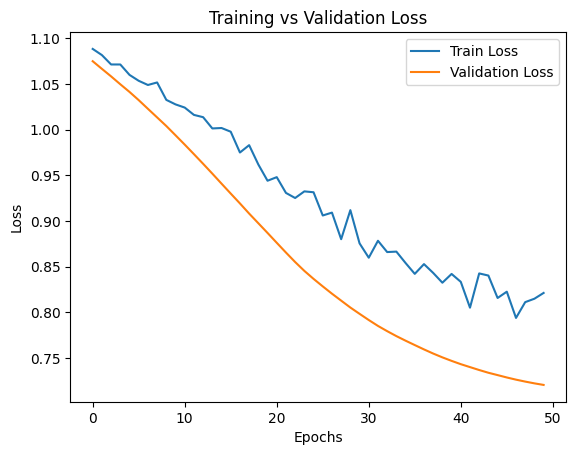

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.plot(range(epochs), train_losses, label="Train Loss")
plt.plot(range(epochs), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()
wandb.log({"loss_curve": wandb.Image(plt)})


In [ ]:
model.eval()
y_pred_list, y_true_list = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        y_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
        y_true_list.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

accuracy = accuracy_score(y_true_list, y_pred_list)
precision = precision_score(y_true_list, y_pred_list, average="weighted")
recall = recall_score(y_true_list, y_pred_list, average="weighted")
f1 = f1_score(y_true_list, y_pred_list, average="weighted")
cm = confusion_matrix(y_true_list, y_pred_list)

print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
wandb.log({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1})


Accuracy: 0.7667, Precision: 0.8833, Recall: 0.7667, F1-score: 0.7511


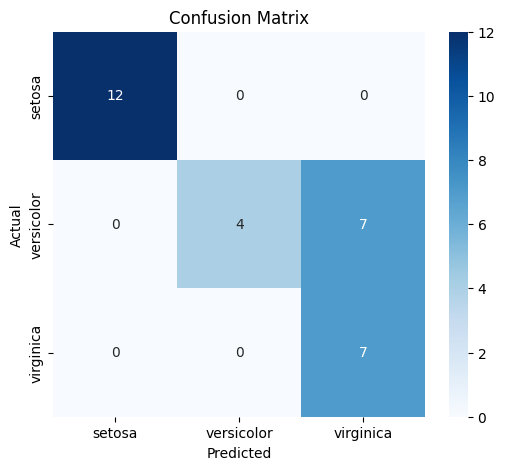

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.target_names, yticklabels=dataset.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
wandb.log({"confusion_matrix": wandb.Image(plt)})


#SECTION 2


# Task 1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(4, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


In [ ]:
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

results = []



Training Model with Batch Size=2, LR=0.001, Epochs=1
Accuracy: 0.3333, F1-score: 0.2708


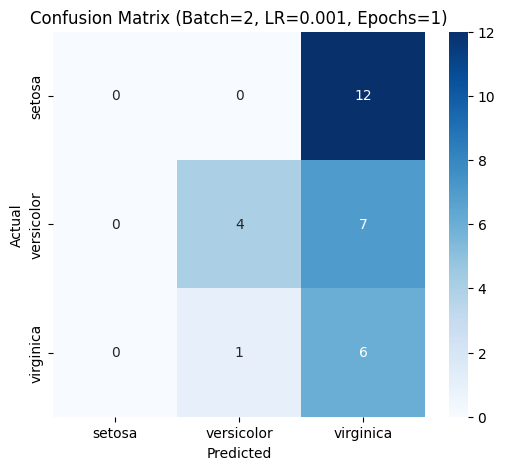


Training Model with Batch Size=2, LR=0.001, Epochs=3
Accuracy: 0.6333, F1-score: 0.5040


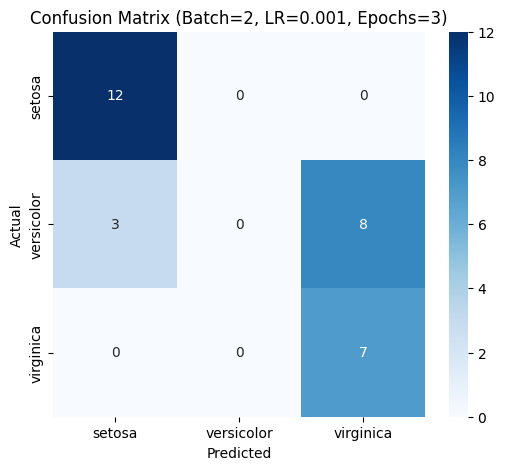


Training Model with Batch Size=2, LR=0.001, Epochs=5
Accuracy: 0.7667, F1-score: 0.7511


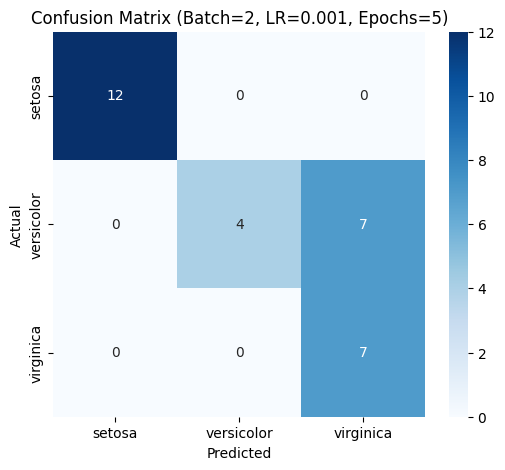


Training Model with Batch Size=2, LR=1e-05, Epochs=1
Accuracy: 0.2667, F1-score: 0.1576


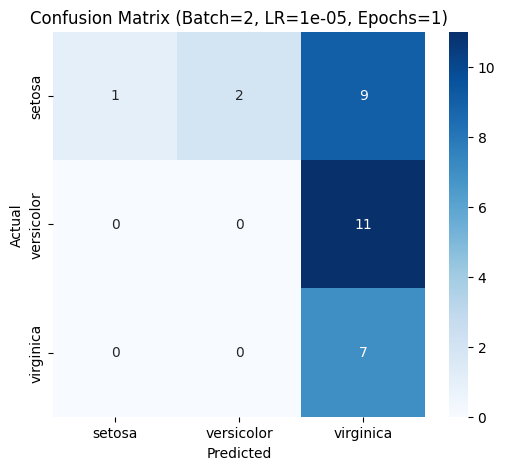


Training Model with Batch Size=2, LR=1e-05, Epochs=3
Accuracy: 0.0000, F1-score: 0.0000


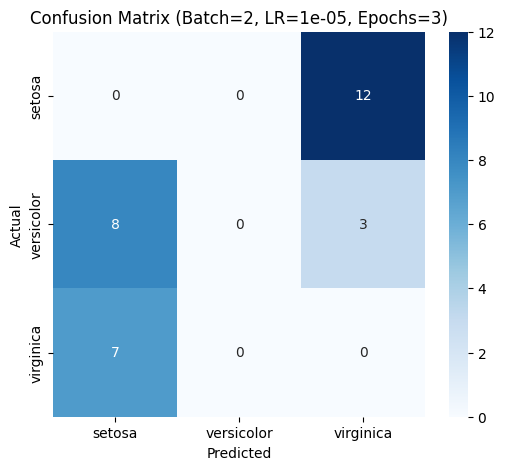


Training Model with Batch Size=2, LR=1e-05, Epochs=5
Accuracy: 0.9333, F1-score: 0.9342


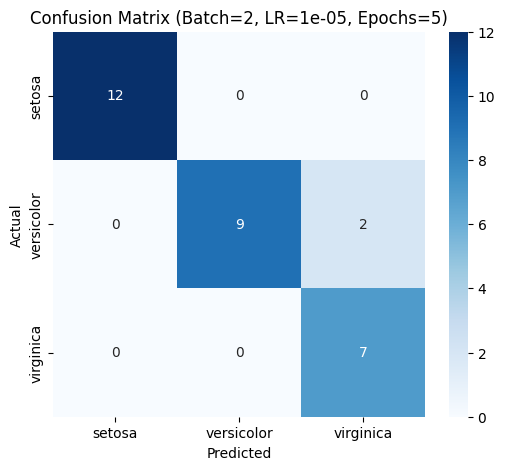


Training Model with Batch Size=4, LR=0.001, Epochs=1
Accuracy: 0.2667, F1-score: 0.1833


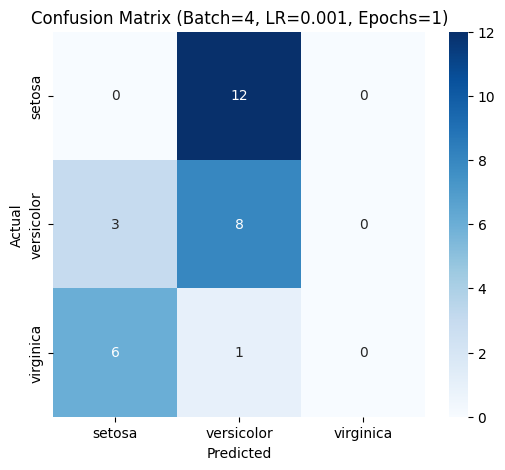


Training Model with Batch Size=4, LR=0.001, Epochs=3
Accuracy: 0.6333, F1-score: 0.5307


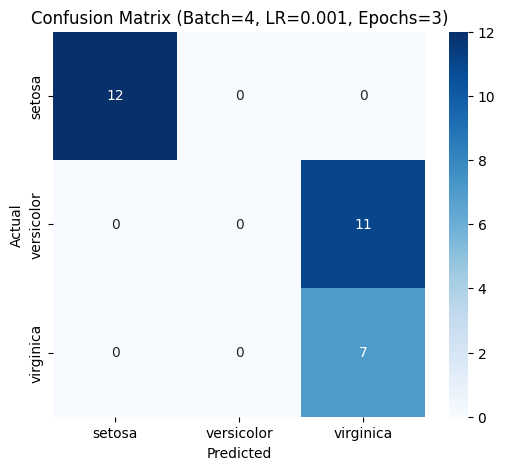


Training Model with Batch Size=4, LR=0.001, Epochs=5
Accuracy: 0.8333, F1-score: 0.8308


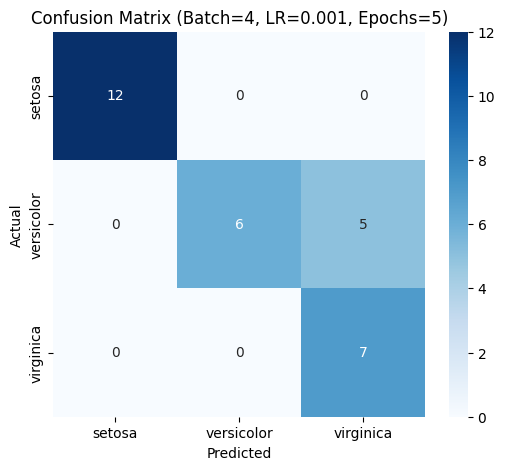


Training Model with Batch Size=4, LR=1e-05, Epochs=1
Accuracy: 0.5667, F1-score: 0.4946


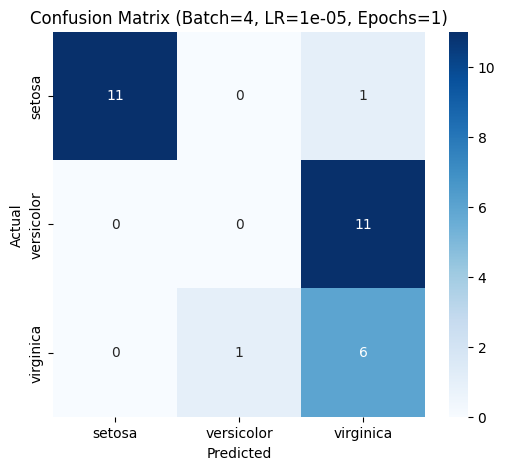


Training Model with Batch Size=4, LR=1e-05, Epochs=3
Accuracy: 0.3667, F1-score: 0.1967


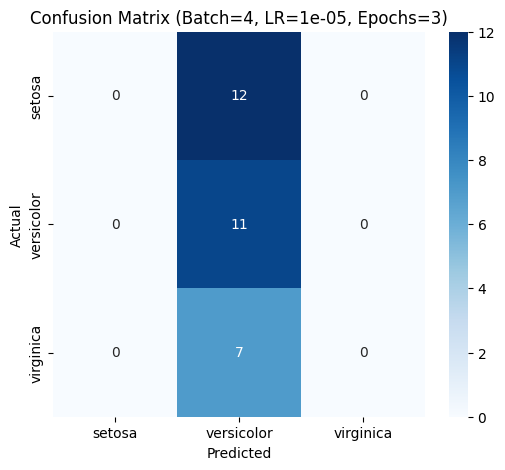


Training Model with Batch Size=4, LR=1e-05, Epochs=5
Accuracy: 0.2667, F1-score: 0.2227


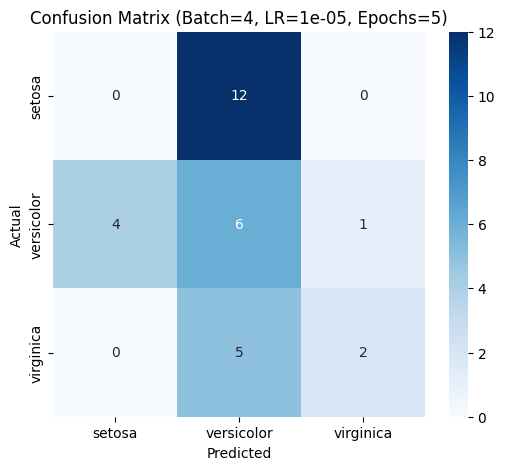

In [ ]:
for batch_size, lr, epochs in itertools.product(batch_sizes, learning_rates, epochs_list):
    print(f"\nTraining Model with Batch Size={batch_size}, LR={lr}, Epochs={epochs}")

    model = MLP()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(data.TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    y_pred_list, y_true_list = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            y_pred_list.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
            y_true_list.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

    accuracy = accuracy_score(y_true_list, y_pred_list)
    f1 = f1_score(y_true_list, y_pred_list, average="weighted")
    cm = confusion_matrix(y_true_list, y_pred_list)

    print(f"Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}")

    results.append({
        "Batch Size": batch_size,
        "Learning Rate": lr,
        "Epochs": epochs,
        "Accuracy": accuracy,
        "F1 Score": f1
    })

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.target_names, yticklabels=dataset.target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Batch={batch_size}, LR={lr}, Epochs={epochs})")
    plt.show()


In [ ]:
df_results = pd.DataFrame(results)
print("\nFinal Results:\n", df_results)



Final Results:
     Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0            2        0.00100       1  0.333333  0.270833
1            2        0.00100       3  0.633333  0.504040
2            2        0.00100       5  0.766667  0.751111
3            2        0.00001       1  0.266667  0.157617
4            2        0.00001       3  0.000000  0.000000
5            2        0.00001       5  0.933333  0.934167
6            4        0.00100       1  0.266667  0.183333
7            4        0.00100       3  0.633333  0.530667
8            4        0.00100       5  0.833333  0.830753
9            4        0.00001       1  0.566667  0.494609
10           4        0.00001       3  0.366667  0.196748
11           4        0.00001       5  0.266667  0.222745


In [ ]:
print("\nSample Predictions:")
sample_indices = np.random.choice(len(X_test), 5, replace=False)
X_sample, y_sample = X_test[sample_indices], y_test[sample_indices]

with torch.no_grad():
    y_pred_sample = model(X_sample)
    y_pred_sample = torch.argmax(y_pred_sample, dim=1).cpu().numpy()
    y_true_sample = torch.argmax(y_sample, dim=1).cpu().numpy()

for i in range(5):
    print(f"Sample {i+1}:")
    print(f"  Input: {X_sample[i].numpy()}")
    print(f"  Prediction: {dataset.target_names[y_pred_sample[i]]}")
    print(f"  Truth: {dataset.target_names[y_true_sample[i]]}\n")




Sample Predictions:
Sample 1:
  Input: [2.4804983 1.896035  1.4765439 1.0294614]
  Prediction: virginica
  Truth: virginica

Sample 2:
  Input: [ 0.3100623  -0.5025635   0.484213   -0.05282593]
  Prediction: versicolor
  Truth: versicolor

Sample 3:
  Input: [-0.7751557  2.6156144 -1.383704  -1.540971 ]
  Prediction: versicolor
  Truth: setosa

Sample 4:
  Input: [-0.05167705 -0.74242336  0.01723376 -0.05282593]
  Prediction: versicolor
  Truth: versicolor

Sample 5:
  Input: [-1.2574749  -0.02284379 -1.4420763  -1.540971  ]
  Prediction: versicolor
  Truth: setosa



Task 2

In [ ]:
!python --version

Python 3.11.11


In [ ]:
!wget -O mini.sh https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh
!chmod +x mini.sh
!bash ./mini.sh -b -f -p /usr/local
!conda install -q -y jupyter
!conda install -q -y google-colab -c conda-forge
!python -m ipykernel install --name "py39" --user

--2025-02-26 15:06:35--  https://repo.anaconda.com/miniconda/Miniconda3-py39_4.9.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.191.158, 104.16.32.241, 2606:4700::6810:bf9e, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.191.158|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61451533 (59M) [application/x-sh]
Saving to: ‘mini.sh’

mini.sh             100%[===================>]  58.60M   119MB/s    in 0.5s    

2025-02-26 15:06:36 (119 MB/s) - ‘mini.sh’ saved [61451533/61451533]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - brotlipy==0.7.0=py39h27cfd23_1003
    - ca-certificates==2020.12.8=h06a4308_0
    - certifi==2020.12.5=py39h06a4308_0
    - cffi==1.14.4=py39h261ae71_0
    - chardet==3.0.4=py39h06a4308_1003
    - conda-package-handling==1.7.2=py39h27cfd23_1
    - c

In [ ]:
!python --version

Python 3.9.21


In [ ]:
pip install --upgrade "autogluon>=0.9"


  Using cached autogluon-1.2-py3-none-any.whl (9.6 kB)
  Using cached autogluon.core-1.2-py3-none-any.whl (266 kB)
  Using cached autogluon.common-1.2-py3-none-any.whl (68 kB)
  Using cached autogluon.features-1.2-py3-none-any.whl (64 kB)
  Using cached autogluon.multimodal-1.2-py3-none-any.whl (429 kB)
  Using cached accelerate-0.34.2-py3-none-any.whl (324 kB)
  Using cached autogluon.tabular-1.2-py3-none-any.whl (352 kB)
  Using cached autogluon.timeseries-1.2-py3-none-any.whl (174 kB)
  Using cached boto3-1.37.1-py3-none-any.whl (139 kB)
  Using cached botocore-1.37.1-py3-none-any.whl (13.4 MB)
  Using cached catboost-1.2.7-cp39-cp39-manylinux2014_x86_64.whl (98.7 MB)
  Using cached coreforecast-0.0.12-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (196 kB)
  Using cached einops-0.8.1-py3-none-any.whl (64 kB)
  Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)
  Using cached datasets-3.3.2-py3-none-any.whl (485 kB)
  Using cached dill-0.3.8-py3-none-any.whl (116 kB)
  Us

In [ ]:
!pip install --upgrade scikit-learn


  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-tabular 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-core 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.6.1 which is incompatible.
autogluon-features 1.2 requires scikit-learn<1.5.3,>=1.4.0, but you have scikit-learn 1.6.1 whic

In [ ]:
X_train_np = X_train.numpy()
y_train_np = np.argmax(y_train.numpy(), axis=1)  # Convert one-hot to labels
X_test_np = X_test.numpy()
y_test_np = np.argmax(y_test.numpy(), axis=1)

train_df = pd.DataFrame(X_train_np, columns=[f'feature_{i}' for i in range(X_train_np.shape[1])])
train_df['target'] = y_train_np

test_df = pd.DataFrame(X_test_np, columns=[f'feature_{i}' for i in range(X_test_np.shape[1])])
test_df['target'] = y_test_np

train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['target'])



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.common as ag

from sklearn.datasets import load_iris
from sklearn.metrics import f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from autogluon.tabular import TabularPredictor
import pandas as pd

hyperparameters_grid = {
    'GBM': {'learning_rate': [0.1], 'max_depth': [3], 'num_boost_round': [50]}
}

predictor_grid = TabularPredictor(label='target').fit(
    train_data=train_data,
    tuning_data=val_data,
    hyperparameters=hyperparameters_grid,
    time_limit=600,
    verbosity=3
)


No path specified. Models will be saved in: "AutogluonModels/ag-20250226_162211"
Verbosity: 3 (Detailed Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
GPU Count:          1
Memory Avail:       9.95 GB / 12.67 GB (78.5%)
Disk Space Avail:   75.10 GB / 112.64 GB (66.7%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users.

RuntimeError: No models were trained successfully during fit(). Inspect the log output or increase verbosity to determine why no models were fit. Alternatively, set `raise_on_no_models_fitted` to False during the fit call.